In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
# Set random seed for reproducibility
manualSeed = 12
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Random Seed:  12


## Dataset Introduction
This dataset contains two sets.

The first set is all goods, the second set contains goods and defective products.

You need to classify the products into defective ones or not, and calculate the accuracy.

The benchmark is accuracy.

## bottle

In [2]:
image_size = 256

class SubsetImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_classes=None):
        super().__init__(root, transform)
        if target_classes is not None:
            target_idx = [self.class_to_idx[cls] for cls in target_classes]
            self.samples = [sample for sample in self.samples if sample[1] in target_idx]
            self.targets = [s[1] for s in self.samples]
            self.imgs = self.samples

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  
    # # transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform, target_classes=['bottle'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SubsetImageFolder(root='./VAE_Data/data/val', transform=transform, target_classes=['bottle'])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset)) 

train:  167
val:  42


In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3080 , device num:0


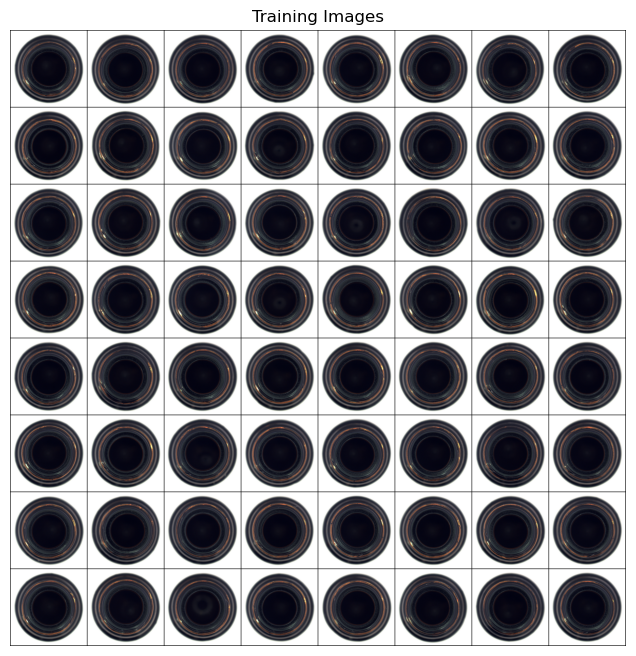

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder =nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # [32, 128, 128]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # [64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [128, 32, 32]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # [256, 16, 16]
            nn.ReLU(),
            nn.Flatten(), 
        )

        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim) 
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim) 
        self.decoder_fc = nn.Linear(latent_dim, 256 * 16 * 16)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # [128, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # [32, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # [3, 256, 256]
            nn.Sigmoid() 
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder_fc(z).view(-1, 256, 16, 16)
        recon_x = self.decoder(decoded)
        return recon_x, mu, logvar
    

In [6]:
model = VAE(128).to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=65536, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=65536, out_features=128, bias=True)
  (decoder_fc): Linear(in_features=128, out_features=65536, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2

In [ ]:
# use vgg16 to calculate perceptual loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16].eval()  
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, recon_x, x):
        device = recon_x.device  
        self.vgg = self.vgg.to(device) 
        
        recon_x = recon_x.to(device).float()
        x = x.to(device).float()

        # get features from vgg16
        recon_features = self.vgg(recon_x)
        x_features = self.vgg(x)
        loss = nn.functional.mse_loss(recon_features, x_features, reduction='sum')
        return loss

In [ ]:
def loss_function(recon_x, x, mu, logvar, perceptual_weight = 0.2):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # add perceptual loss
    perceptual_loss = PerceptualLoss()(recon_x, x)  
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = (recon_loss + perceptual_weight * perceptual_loss + kl_divergence) / x.size(0)
    return loss

In [8]:
def train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon, mu, logvar = model(data)
                val_loss += loss_function(recon, data, mu, logvar).item()
        val_losses.append(val_loss / len(val_loader.dataset))    

        print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}, Val Loss: {val_loss / len(val_loader.dataset):.4f}")
    scheduler.step(val_loss)
    return train_losses, val_losses

In [12]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=500)
torch.save(model.state_dict(), './model_weight/bottle.pth')

Epoch 1, Loss: 7109.5715, Val Loss: 9255.4368
Epoch 2, Loss: 6961.8428, Val Loss: 9179.2269
Epoch 3, Loss: 6856.0992, Val Loss: 9446.3237
Epoch 4, Loss: 6847.8084, Val Loss: 8915.4799
Epoch 5, Loss: 6631.9373, Val Loss: 8603.9807
Epoch 6, Loss: 6394.8838, Val Loss: 8266.5707
Epoch 7, Loss: 6151.8417, Val Loss: 7915.4100
Epoch 8, Loss: 5856.1269, Val Loss: 7489.7329
Epoch 9, Loss: 5527.9822, Val Loss: 6994.2946
Epoch 10, Loss: 5160.6287, Val Loss: 6515.8624
Epoch 11, Loss: 4807.4387, Val Loss: 6111.2377
Epoch 12, Loss: 4511.3398, Val Loss: 5756.2972
Epoch 13, Loss: 4259.0929, Val Loss: 5460.2344
Epoch 14, Loss: 4055.6398, Val Loss: 5207.1752
Epoch 15, Loss: 3875.6125, Val Loss: 4995.9059
Epoch 16, Loss: 3730.1214, Val Loss: 4811.9081
Epoch 17, Loss: 3600.6636, Val Loss: 4651.2199
Epoch 18, Loss: 3480.0887, Val Loss: 4503.7954
Epoch 19, Loss: 3372.5482, Val Loss: 4368.3307
Epoch 20, Loss: 3284.1566, Val Loss: 4241.2511
Epoch 21, Loss: 3179.7467, Val Loss: 4114.2519
Epoch 22, Loss: 3090.0

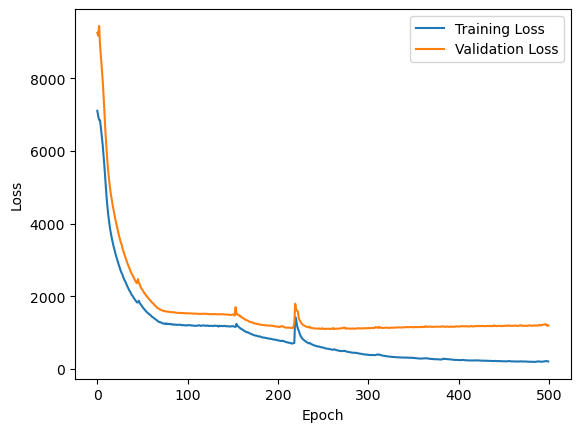

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Calculate the reconstruction loss
The reconstruction loss between good products and defective products should have difference.

You can use the following codes to evaluate the reconstruction loss, and find something useful information.

good avg:  57505.165625
defective avg:  107062.80090525794


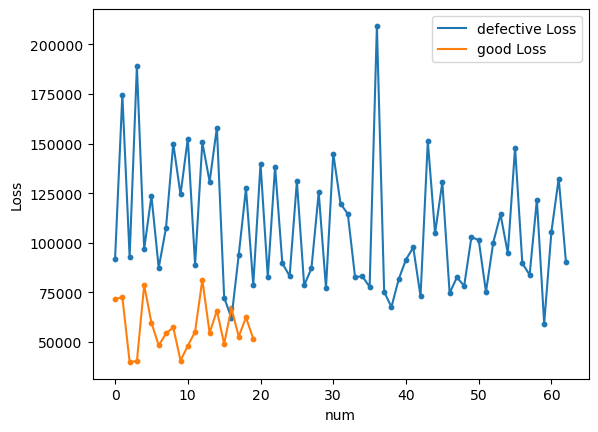

In [109]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

def test(image_path, vae, device):
    img = Image.open(image_path)
    img = transform(img).to(device)
    img = img.unsqueeze(0)

    vae.eval()
    with torch.no_grad():
        recon, mu, log_var = vae(img)
        test_loss = loss_function(recon, img, mu, log_var)
        return test_loss.item()

testimg_dir = './VAE_Data/data/test/bottle/good'
testimg_dir2 = './VAE_Data/data/test/bottle/error'
state_dict = torch.load('./model_weight/bottle.pth', weights_only=True)
model.load_state_dict(state_dict)

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

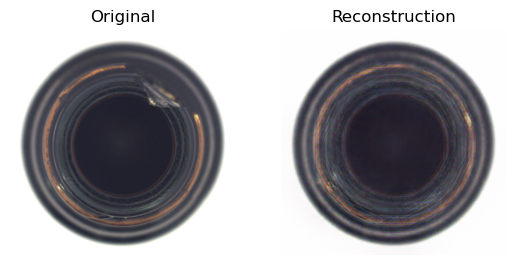

In [ ]:
# visualize the reconstruction
test_dataset = SubsetImageFolder(root='./VAE_Data/data/test/bottle', transform=transform, target_classes=['error'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(data.cpu().squeeze().permute(1, 2, 0))  
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(recon.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")

    plt.show()

## Calculate Accuracy
You need to calculate the accuracy of products' predictions. 

A easy way is to use the reconstruction loss to distinguish between goods and defective ones.

It is not restricted to use this way, you also can use another methods and write they into report.

In [ ]:
def calculate_accuracy():
    total = 0
    correct = 0
    # test good image
    for img_file in os.listdir(testimg_dir):
        img_path = os.path.join(testimg_dir, img_file)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = transform(img).to(device).unsqueeze(0)

            model.eval()
            with torch.no_grad():
                recon, mu, log_var = model(img)
                test_loss = loss_function(recon, img, mu, log_var).item()

            total += 1
            if test_loss <= threshold: 
                correct += 1

    # test error image
    for img_file in os.listdir(testimg_dir2):
        img_path = os.path.join(testimg_dir2, img_file)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = transform(img).to(device).unsqueeze(0)

            model.eval()
            with torch.no_grad():
                recon, mu, log_var = model(img)
                test_loss = loss_function(recon, img, mu, log_var).item()

            total += 1
            if test_loss > threshold: 
                correct += 1

    accuracy = correct / total * 100 
    return accuracy

In [ ]:
threshold = sum(good)/len(good)

print(f"Accuracy: {calculate_accuracy():.2f}%")

Accuracy: 90.36%


## cable

train:  179
val:  45


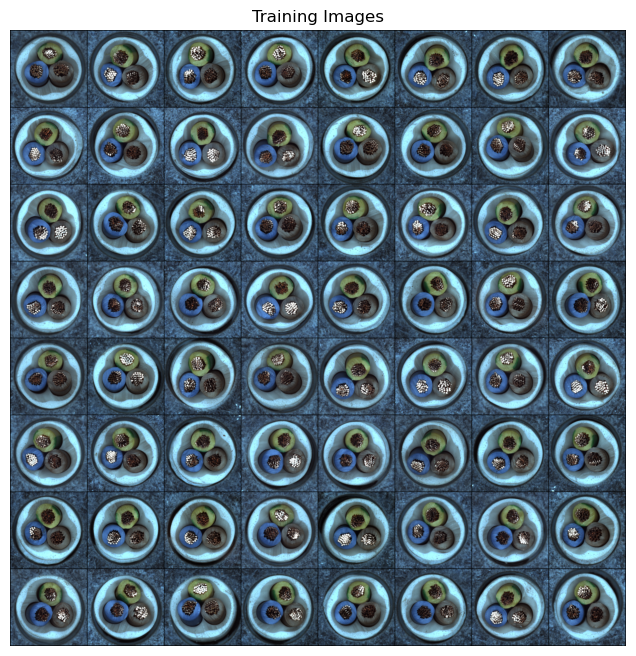

In [11]:
train_dataset = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform, target_classes=['cable'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SubsetImageFolder(root='./VAE_Data/data/val', transform=transform, target_classes=['cable'])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset)) 

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [12]:
perceptual_weight = 0.1
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=500)
torch.save(model.state_dict(), './model_weight/cable.pth')

Epoch 1, Loss: 9669.0642, Val Loss: 12399.2750
Epoch 2, Loss: 9525.5356, Val Loss: 12320.7222
Epoch 3, Loss: 9344.5349, Val Loss: 12227.7778
Epoch 4, Loss: 9218.9815, Val Loss: 11943.4722
Epoch 5, Loss: 9030.8331, Val Loss: 11763.1389
Epoch 6, Loss: 8897.1418, Val Loss: 11591.1014
Epoch 7, Loss: 8760.5705, Val Loss: 11370.4833
Epoch 8, Loss: 8568.0409, Val Loss: 11119.0035
Epoch 9, Loss: 8391.5115, Val Loss: 10919.6104
Epoch 10, Loss: 8239.3128, Val Loss: 10743.0889
Epoch 11, Loss: 8118.5295, Val Loss: 10606.4368
Epoch 12, Loss: 8013.8584, Val Loss: 10489.6153
Epoch 13, Loss: 7926.4148, Val Loss: 10399.1132
Epoch 14, Loss: 7866.1840, Val Loss: 10314.4722
Epoch 15, Loss: 7793.1650, Val Loss: 10238.2083
Epoch 16, Loss: 7741.9944, Val Loss: 10178.6785
Epoch 17, Loss: 7694.2456, Val Loss: 10117.2014
Epoch 18, Loss: 7642.5992, Val Loss: 10058.4306
Epoch 19, Loss: 7609.1899, Val Loss: 10013.9271
Epoch 20, Loss: 7567.0450, Val Loss: 9968.6632
Epoch 21, Loss: 7532.5005, Val Loss: 9932.7132
Epo

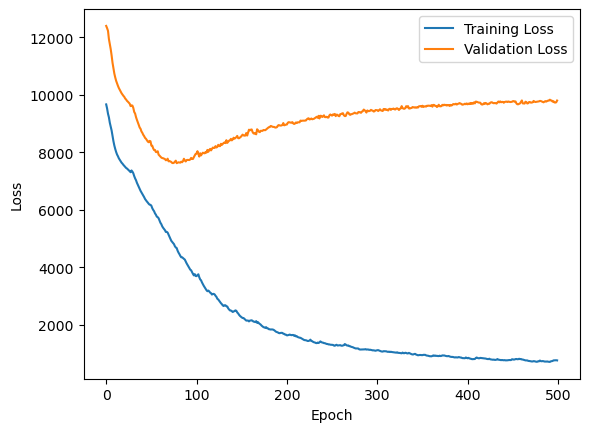

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

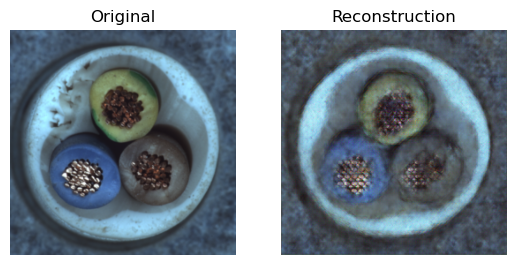

In [ ]:
# visualize the reconstruction
test_dataset = SubsetImageFolder(root='./VAE_Data/data/test/cable', transform=transform, target_classes=['error'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(data.cpu().squeeze().permute(1, 2, 0))  
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(recon.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")

    plt.show()

good avg:  430409.7780172414
defective avg:  494640.2503396739


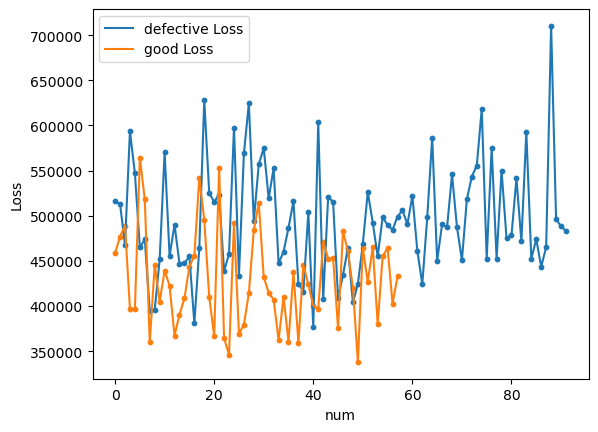

In [23]:
testimg_dir = './VAE_Data/data/test/cable/good'
testimg_dir2 = './VAE_Data/data/test/cable/error'

state_dict = torch.load('./model_weight/cable.pth', weights_only=True)
model.load_state_dict(state_dict)

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

In [24]:
threshold = 446000

print(f"Accuracy: {calculate_accuracy():.2f}%")

Accuracy: 76.00%


## capsule

In [25]:
transform = transforms.Compose([
    transforms.CenterCrop(900),
    # transforms.ColorJitter(contrast=(1.2, 1.2)),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train:  175
val:  44


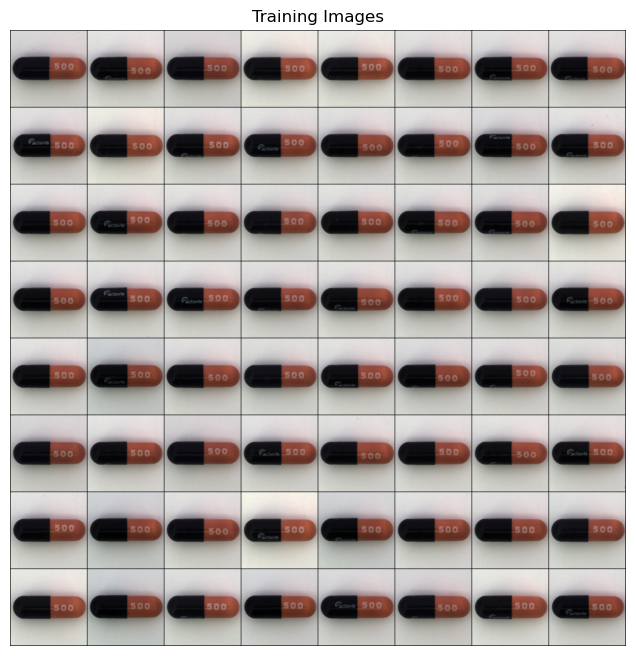

In [26]:
train_dataset = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform, target_classes=['capsule'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SubsetImageFolder(root='./VAE_Data/data/val', transform=transform, target_classes=['capsule'])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset))

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [27]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=500)
torch.save(model.state_dict(), './model_weight/capsule.pth')

Epoch 1, Loss: 3293.1679, Val Loss: 3829.7067
Epoch 2, Loss: 2847.2781, Val Loss: 3753.2106
Epoch 3, Loss: 2814.8305, Val Loss: 3746.8558
Epoch 4, Loss: 2807.2449, Val Loss: 3683.0224
Epoch 5, Loss: 2765.7753, Val Loss: 3669.2070
Epoch 6, Loss: 2748.5178, Val Loss: 3628.5007
Epoch 7, Loss: 2713.1941, Val Loss: 3568.5263
Epoch 8, Loss: 2648.6950, Val Loss: 3522.1222
Epoch 9, Loss: 2601.5237, Val Loss: 3369.2678
Epoch 10, Loss: 2495.5023, Val Loss: 3203.3732
Epoch 11, Loss: 2357.2858, Val Loss: 2994.4567
Epoch 12, Loss: 2198.1751, Val Loss: 2825.2852
Epoch 13, Loss: 2059.7713, Val Loss: 2633.6026
Epoch 14, Loss: 1935.6351, Val Loss: 2499.5332
Epoch 15, Loss: 1840.5609, Val Loss: 2396.6948
Epoch 16, Loss: 1764.8772, Val Loss: 2308.3198
Epoch 17, Loss: 1702.4021, Val Loss: 2228.9766
Epoch 18, Loss: 1653.2408, Val Loss: 2161.6932
Epoch 19, Loss: 1602.6901, Val Loss: 2112.4171
Epoch 20, Loss: 1567.7186, Val Loss: 2067.0403
Epoch 21, Loss: 1538.3807, Val Loss: 2029.3137
Epoch 22, Loss: 1510.4

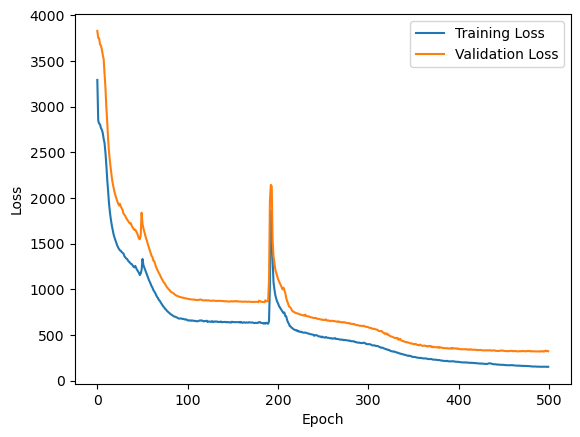

In [28]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

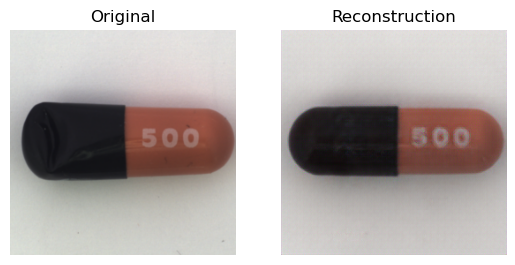

In [ ]:
# visualize the reconstruction
test_dataset = SubsetImageFolder(root='./VAE_Data/data/test/capsule', transform=transform, target_classes=['error'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(data.cpu().squeeze().permute(1, 2, 0))  
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(recon.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")

    plt.show()

good avg:  15547.028532608696
defective avg:  30200.2743334289


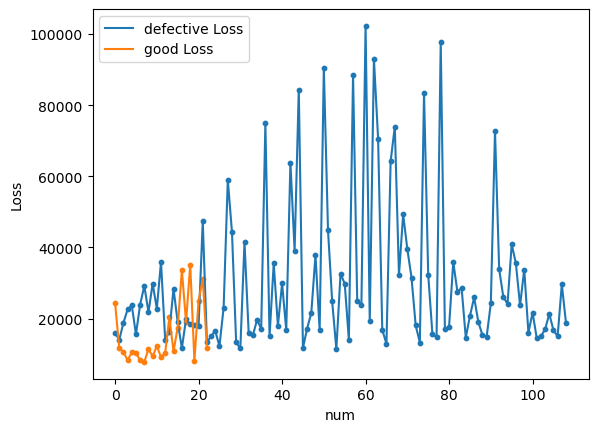

In [ ]:
testimg_dir = './VAE_Data/data/test/capsule/good'
testimg_dir2 = './VAE_Data/data/test/capsule/error'
state_dict = torch.load('./model_weight/capsule.pth', weights_only=True)
model.load_state_dict(state_dict)

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

In [31]:
threshold = min(error) 

print(f"Accuracy: {calculate_accuracy():.2f}%")

Accuracy: 90.91%


## pill

In [111]:
transform = transforms.Compose([
    transforms.CenterCrop(750),
    transforms.ColorJitter(contrast=(1.1, 1.1), saturation=(1.1, 1.1)),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train:  213
val:  54


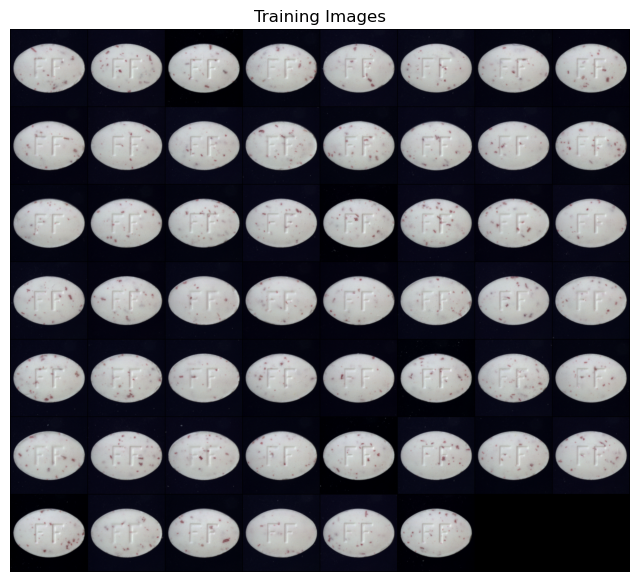

In [112]:
train_dataset = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform, target_classes=['pill'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SubsetImageFolder(root='./VAE_Data/data/val', transform=transform, target_classes=['pill'])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset)) 

real_batch = next(iter(val_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [ ]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=500)
torch.save(model.state_dict(), './model_weight/pill.pth')

Epoch 1, Loss: 4906.8374, Val Loss: 4672.4332
Epoch 2, Loss: 4797.6075, Val Loss: 4672.8313
Epoch 3, Loss: 4762.8117, Val Loss: 4590.6036
Epoch 4, Loss: 4715.4940, Val Loss: 4521.7486
Epoch 5, Loss: 4618.6334, Val Loss: 4425.7546
Epoch 6, Loss: 4501.3052, Val Loss: 4297.2133
Epoch 7, Loss: 4364.2402, Val Loss: 4105.8996
Epoch 8, Loss: 4086.3209, Val Loss: 3774.6756
Epoch 9, Loss: 3786.3638, Val Loss: 3501.4071
Epoch 10, Loss: 3527.4040, Val Loss: 3291.0182
Epoch 11, Loss: 3330.9583, Val Loss: 3134.6348
Epoch 12, Loss: 3204.1890, Val Loss: 3005.7491
Epoch 13, Loss: 3059.8080, Val Loss: 2896.6765
Epoch 14, Loss: 2966.5152, Val Loss: 2805.7104
Epoch 15, Loss: 2871.2025, Val Loss: 2724.3738
Epoch 16, Loss: 2800.7662, Val Loss: 2655.2358
Epoch 17, Loss: 2731.2105, Val Loss: 2594.7659
Epoch 18, Loss: 2661.2071, Val Loss: 2531.9867
Epoch 19, Loss: 2615.6036, Val Loss: 2478.7948
Epoch 20, Loss: 2565.1166, Val Loss: 2431.8397
Epoch 21, Loss: 2512.1588, Val Loss: 2385.1191
Epoch 22, Loss: 2458.2

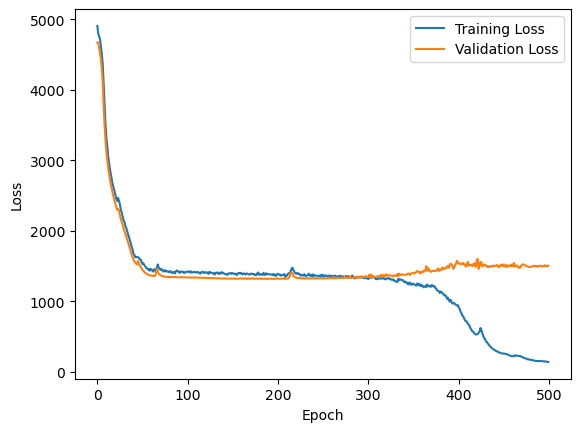

In [35]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

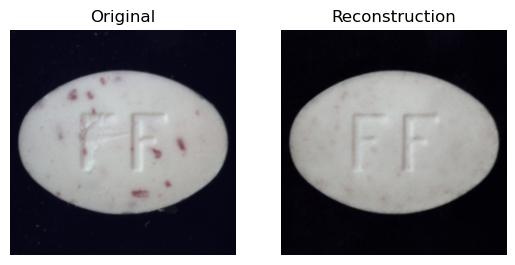

In [ ]:
# visualize the reconstruction
test_dataset = SubsetImageFolder(root='./VAE_Data/data/test/pill', transform=transform, target_classes=['error'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(data.cpu().squeeze().permute(1, 2, 0))  
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(recon.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")

    plt.show()

good avg:  79282.85907451923
defective avg:  99675.52642952128


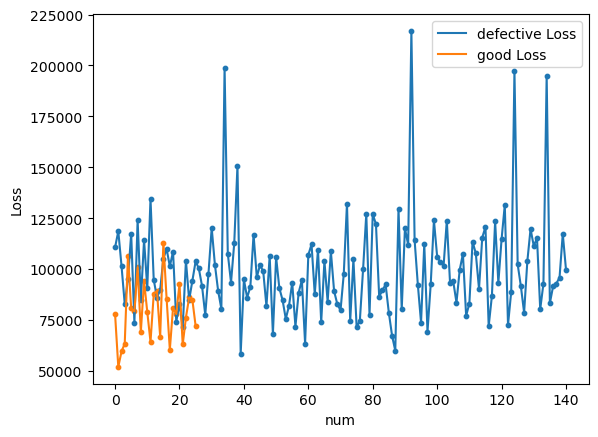

In [113]:
testimg_dir = './VAE_Data/data/test/pill/good'
testimg_dir2 = './VAE_Data/data/test/pill/error'
state_dict = torch.load('./model_weight/pill.pth', weights_only=True)
model.load_state_dict(state_dict)

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

In [122]:
threshold = 69100

print(f"Accuracy: {calculate_accuracy():.2f}%")

Accuracy: 85.63%


## toothbrush

In [4]:
transform_origin = transforms.Compose([
    transforms.CenterCrop(850),
    transforms.ColorJitter(contrast=(1.2, 1.2)),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform = transforms.Compose([
    transforms.CenterCrop(850),
    transforms.RandomHorizontalFlip(1),  # 隨機水平翻轉
    transforms.ColorJitter(contrast=(1.2, 1.2)),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train:  96
val:  12


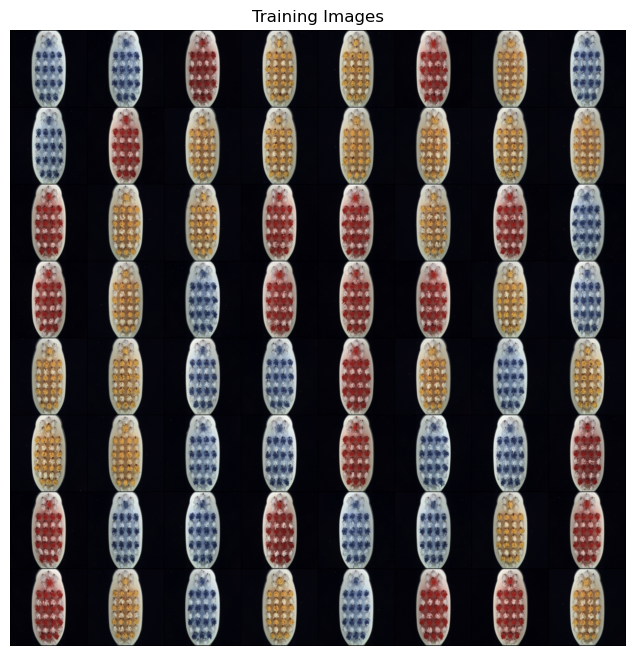

In [5]:
from torch.utils.data import ConcatDataset
train_dataset_origin = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform_origin, target_classes=['toothbrush'])
train_dataset_process = SubsetImageFolder(root='./VAE_Data/data/train', transform=transform, target_classes=['toothbrush'])
train_dataset = ConcatDataset([train_dataset_origin, train_dataset_process])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = SubsetImageFolder(root='./VAE_Data/data/val', transform=transform_origin, target_classes=['toothbrush'])
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset)) 

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [42]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=500)
torch.save(model.state_dict(), './model_weight/toothbrush.pth')

Epoch 1, Loss: 8749.4417, Val Loss: 35553.2708
Epoch 2, Loss: 8704.2458, Val Loss: 35294.2891
Epoch 3, Loss: 8678.3493, Val Loss: 35184.4974
Epoch 4, Loss: 8648.2109, Val Loss: 35122.1849
Epoch 5, Loss: 8570.8285, Val Loss: 34920.7083
Epoch 6, Loss: 8565.9023, Val Loss: 34096.6016
Epoch 7, Loss: 8263.7793, Val Loss: 33278.3073
Epoch 8, Loss: 8135.2656, Val Loss: 32445.6536
Epoch 9, Loss: 7913.9023, Val Loss: 31806.7917
Epoch 10, Loss: 7818.3822, Val Loss: 31349.8307
Epoch 11, Loss: 7674.3682, Val Loss: 31029.7786
Epoch 12, Loss: 7575.3278, Val Loss: 30600.5260
Epoch 13, Loss: 7451.3385, Val Loss: 30072.9844
Epoch 14, Loss: 7294.5983, Val Loss: 29501.9766
Epoch 15, Loss: 7164.9336, Val Loss: 28848.7578
Epoch 16, Loss: 6989.0387, Val Loss: 28178.3359
Epoch 17, Loss: 6809.9717, Val Loss: 27269.4505
Epoch 18, Loss: 6610.5179, Val Loss: 26304.3854
Epoch 19, Loss: 6387.4720, Val Loss: 25524.4948
Epoch 20, Loss: 6233.0833, Val Loss: 24841.6484
Epoch 21, Loss: 6045.4046, Val Loss: 24212.8073
E

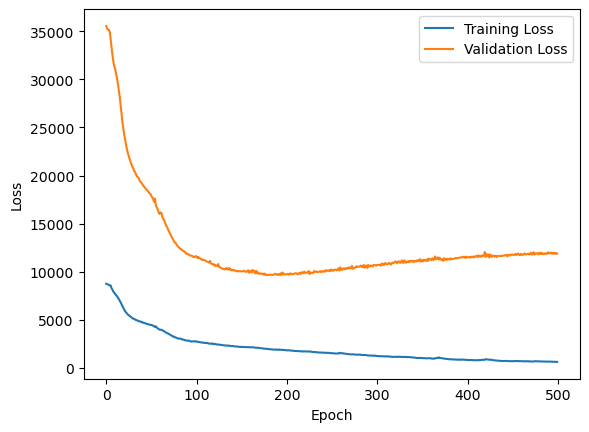

In [43]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

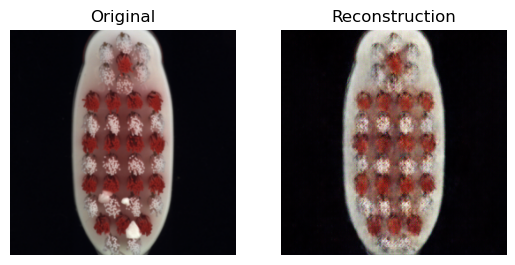

In [ ]:
# visualize the reconstruction
test_dataset = SubsetImageFolder(root='./VAE_Data/data/test/toothbrush', transform=transform, target_classes=['error'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(data.cpu().squeeze().permute(1, 2, 0))  
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(recon.cpu().squeeze().permute(1, 2, 0))
    plt.axis("off")

    plt.show()

good avg:  138524.73177083334
defective avg:  226638.87552083333


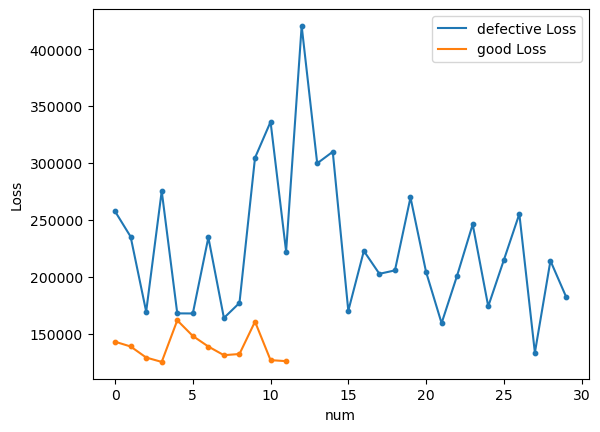

In [125]:
testimg_dir = './VAE_Data/data/test/toothbrush/good'
testimg_dir2 = './VAE_Data/data/test/toothbrush/error'
state_dict = torch.load('./model_weight/toothbrush.pth', weights_only=True)
model.load_state_dict(state_dict)

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

In [126]:
threshold = max(good)

print(f"Accuracy: {calculate_accuracy():.2f}%")

Accuracy: 95.24%
